## 計算速度

### 先照之前的，讀取資料

In [1]:
import tqdm
import tarfile
import pandas
import matplotlib.pyplot as plt
import numpy as np
import PIL
import gzip
from urllib.request import urlopen
%matplotlib inline
# progress bar
tqdm.tqdm.pandas()

# 檔案名稱格式
filename_format="M06A_{year:04d}{month:02d}{day:02d}.tar.gz".format
xz_filename_format="xz/M06A_{year:04d}{month:02d}{day:02d}.tar.xz".format
csv_format = "M06A/{year:04d}{month:02d}{day:02d}/{hour:02d}/TDCS_M06A_{year:04d}{month:02d}{day:02d}_{hour:02d}0000.csv".format

In [2]:
# 打開剛才下載的檔案試試
data_config ={"year":2016, "month":12, "day":18}
tar = tarfile.open(filename_format(**data_config), 'r')

In [3]:
# 如果沒有下載，可以試試看 xz 檔案
#data_dconfig ={"year":2016, "month":11, "day":18}
#tar = tarfile.open(xz_filename_format(**data_config), 'r')

In [4]:
# 設定欄位名稱
M06A_fields = ['VehicleType',
               'DetectionTime_O','GantryID_O',
               'DetectionTime_D','GantryID_D ',
               'TripLength', 'TripEnd', 'TripInformation']
# 打開裡面 10 點鐘的資料
csv = tar.extractfile(csv_format(hour=10, **data_config))

# 讀進資料
data = pandas.read_csv(csv, names=M06A_fields)

# 檢查異常的資料
print("異常資料數:", data[data.TripEnd == 'N'].shape[0])

# 去除異常資料
data = data[data.TripEnd == 'Y']

# 焦點放在 TripInformation 和 VehicleType
data = data[['VehicleType', "TripInformation"]]

# 看前五筆
data.head(5)

異常資料數: 0


,VehicleType,TripInformation
0,31,2016-12-18 10:00:50+01F1045N; 2016-12-18 10:04...
1,31,2016-12-18 10:34:24+01F3525S; 2016-12-18 10:37...
2,31,2016-12-18 10:57:33+03F3854N; 2016-12-18 11:12...
3,31,2016-12-18 10:05:11+03F0525S; 2016-12-18 10:07...
4,31,2016-12-18 10:35:46+01F3185S; 2016-12-18 10:38...


In [5]:
import datetime
# 用來解析時間格式
def strptime(x):
    return datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

In [6]:
def parse_tripinfo(tripinfo):
    split1 = tripinfo.split("; ")
    split2 = (x.split('+') for x in split1)
    return [(strptime(t), node) for t,node in split2]
# 試試看
data.head(10).TripInformation.apply(parse_tripinfo)

0    [(2016-12-18 10:00:50, 01F1045N), (2016-12-18 ...
1    [(2016-12-18 10:34:24, 01F3525S), (2016-12-18 ...
2    [(2016-12-18 10:57:33, 03F3854N), (2016-12-18 ...
3    [(2016-12-18 10:05:11, 03F0525S), (2016-12-18 ...
4    [(2016-12-18 10:35:46, 01F3185S), (2016-12-18 ...
5    [(2016-12-18 10:00:35, 03F3496N), (2016-12-18 ...
6    [(2016-12-18 10:00:21, 05F0287N), (2016-12-18 ...
7    [(2016-12-18 10:50:12, 01H0271N), (2016-12-18 ...
8    [(2016-12-18 10:09:36, 01F0339S), (2016-12-18 ...
9    [(2016-12-18 10:36:58, 01F3696N), (2016-12-18 ...
Name: TripInformation, dtype: object

In [7]:
# 新增一欄
data['Trip'] = data.TripInformation.progress_apply(parse_tripinfo)

100%|██████████| 211247/211247 [00:11<00:00, 17812.28it/s]


## 計算平均速度
計算兩個偵測站之間的速度，只計算同一條路線上的

In [8]:
trip = data['Trip'][0]
trip

[(datetime.datetime(2016, 12, 18, 10, 0, 50), '01F1045N'),
 (datetime.datetime(2016, 12, 18, 10, 4, 37), '01F0979N'),
 (datetime.datetime(2016, 12, 18, 10, 5, 58), '01F0956N'),
 (datetime.datetime(2016, 12, 18, 10, 7, 43), '01F0928N'),
 (datetime.datetime(2016, 12, 18, 10, 10, 43), '01F0880N'),
 (datetime.datetime(2016, 12, 18, 10, 18, 38), '01F0750N'),
 (datetime.datetime(2016, 12, 18, 10, 27, 26), '01H0608N'),
 (datetime.datetime(2016, 12, 18, 10, 29, 1), '01F0584N')]

In [9]:
for (t1,n1), (t2,n2) in zip(trip[:-1], trip[1:]):
    # 去除換路線的
    if n1[:3] != n2[:3] or n1[-1]!=n2[-1]:
        continue
    # 去除額外路線的
    if n1[3]=='R' or n2[3]=='R': 
        continue
    # 從站名取得公里數
    km1 = int(n1[3:-1])/10
    km2 = int(n2[3:-1])/10
    hr_delta = (t2-t1).seconds/60/60
    speed = abs(km2-km1)/hr_delta
    print(speed)
        

104.66960352422898
102.22222222222271
95.9999999999999
95.99999999999994
98.52631578947368


### 包成函數

In [10]:
def compute_speed(trip):
    rtn = []
    for (t1,n1), (t2,n2) in zip(trip[:-1], trip[1:]):
        # 去除換路線的
        if n1[:3] != n2[:3] or n1[-1]!=n2[-1]:
            continue
        # 去除額外路線的
        if n1[3]=='R' or n2[3]=='R': 
            continue
        # 從站名取得公里數
        km1 = int(n1[3:-1])/10
        km2 = int(n2[3:-1])/10
        hr_delta = (t2-t1).seconds/60/60
        speed = abs(km2-km1)/hr_delta
        rtn.append(speed)
    return np.array(rtn)

## Q
將 `compute_speed` 改成 numpy 方式的寫法？

In [11]:
data.head(10).Trip.apply(compute_speed)

0    [104.669603524, 102.222222222, 96.0, 96.0, 98....
1    [76.6863905325, 81.5625, 84.5070422535, 85.263...
2                       [95.2941176471, 94.7368421053]
3                                      [82.7027027027]
4    [103.561643836, 105.882352941, 108.318584071, ...
5                                      [103.728813559]
6    [9.45652173913, 82.7234042553, 100.0, 94.94505...
7                                [87.9069767442, 90.0]
8                                                   []
9                       [83.7209302326, 41.6720257235]
Name: Trip, dtype: object

In [12]:
data['Speed'] = data.Trip.progress_apply(compute_speed)

100%|██████████| 211247/211247 [00:01<00:00, 122173.07it/s]


In [13]:
# 只留下有速度的旅程
valid_idx = data.Speed.apply(len).astype('bool')
valid_data = data[valid_idx].copy()
del valid_data['TripInformation']
valid_data.head()

,VehicleType,Trip,Speed
0,31,"[(2016-12-18 10:00:50, 01F1045N), (2016-12-18 ...","[104.669603524, 102.222222222, 96.0, 96.0, 98...."
1,31,"[(2016-12-18 10:34:24, 01F3525S), (2016-12-18 ...","[76.6863905325, 81.5625, 84.5070422535, 85.263..."
2,31,"[(2016-12-18 10:57:33, 03F3854N), (2016-12-18 ...","[95.2941176471, 94.7368421053]"
3,31,"[(2016-12-18 10:05:11, 03F0525S), (2016-12-18 ...",[82.7027027027]
4,31,"[(2016-12-18 10:35:46, 01F3185S), (2016-12-18 ...","[103.561643836, 105.882352941, 108.318584071, ..."


這樣就能計算旅程中的最高速度

In [14]:
valid_data['MaxSpeed']=valid_data.Speed.apply(max)

In [15]:
valid_data.sort_values('MaxSpeed', ascending=False)

,VehicleType,Trip,Speed,MaxSpeed
98,31,"[(2016-12-18 10:55:40, 03F2261S), (2016-12-18 ...","[114.893617021, 101.886792453, 111.968503937, ...",180.000000
66641,32,"[(2016-12-18 10:06:25, 03F4142N), (2016-12-18 ...","[122.016806723, 138.461538462, 138.633540373, ...",172.800000
130441,31,"[(2016-12-18 10:50:56, 03F2985S), (2016-12-18 ...","[138.737541528, 172.0, 148.965517241, 160.0, 1...",172.000000
44047,31,"[(2016-12-18 10:07:24, 01F3590S), (2016-12-18 ...","[118.421052632, 130.909090909, 171.428571429]",171.428571
51576,31,"[(2016-12-18 10:20:05, 03F1944S), (2016-12-18 ...","[116.689655172, 116.379310345, 106.363636364, ...",169.411765
114582,31,"[(2016-12-18 10:18:50, 03F0525N), (2016-12-18 ...","[164.745762712, 150.491803279, 153.870967742, ...",164.745763
175436,31,"[(2016-12-18 10:21:08, 01F3460N), (2016-12-18 ...","[98.3259911894, 98.4615384615, 14.9843912591, ...",163.125000
109114,31,"[(2016-12-18 10:46:57, 03F2747S), (2016-12-18 ...","[116.129032258, 114.545454545, 123.488372093, ...",163.018868
29966,31,"[(2016-12-18 10:48:35, 03F3496N), (2016-12-18 ...","[132.086330935, 128.053691275, 121.912350598, ...",162.514286
62146,31,"[(2016-12-18 10:04:08, 03F4259N), (2016-12-18 ...","[124.615384615, 143.105590062, 161.379310345, ...",161.379310


## Q
為什麼有些旅程的速限那麼低？
發生了什麼事情？ 用
```python
valid_data.loc[號碼].Trip
```
可以看看

查詢超過最高速限 110 十公里以上的旅程

In [16]:
valid_data.query("MaxSpeed > 120").shape

(5894, 4)

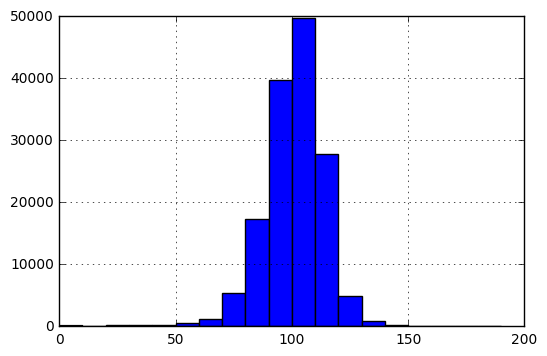

In [17]:
# 看看統計圖表
valid_data.MaxSpeed.hist(bins=np.arange(0,200,10))

## Q
用不同方法畫畫看
如
```python
for vt in [31,32,41,42,5]:
    valid_data[valid_data.VehicleType==vt].MaxSpeed.hist(bins=np.arange(0,200,10))
```
或
```python
for vt in [41,42,5]:
    valid_data[valid_data.VehicleType==vt].MaxSpeed.hist(bins=np.arange(0,200,10), histtype='step')
```

### 最後看看我們抓到多少超速了

In [18]:
num_total = data.shape[0]
num_valid = valid_data.shape[0]
num_overspeed = valid_data.query("MaxSpeed > 120").shape[0]
num_total, num_valid, num_overspeed

(211247, 148719, 5894)

In [19]:
num_overspeed / num_total

0.027900987943024043

In [20]:
num_overspeed / num_valid

0.03963178880976876

### 參考一下國道違規統計的數據

In [21]:
stat_url = "http://www.hpb.gov.tw/files/11-1000-138.php"
國道違規統計 = pandas.read_html(stat_url, attrs={"bordercolor":"#cccccc"}, header=1)[0]
國道違規統計

,違規 項目,104年,103年,102年,101年,100年,99年,98年,97年,96年,95年
0,行駛路肩,27203,16750,14023,12189,12781,16111,15770,24625,35383,40950
1,超速,392444,415784,417088,460826,477775,493017,473948,565548,695921,609328
2,大客車站立乘客,11,6,9,21,23,4,16,25,36,131
3,超載,11380,4413,9938,8618,10079,9789,10497,10498,8866,9937
4,路肩上下客,70,59,51,38,42,27,7,0,7,25
5,無照駕駛,5207,4684,7339,7575,6047,7667,9158,10368,12502,41774
6,酒後駕車,4024,5039,4921,6129,5816,7174,9560,8598,9486,9915
7,不依規定車道行駛,9541,10467,11384,11381,9707,8493,8540,15553,17385,22065
8,任意停車或未擺警告標誌,1565,1282,921,1228,1330,1368,1612,4059,3313,5588
9,任意變換車道,25114,23800,26127,23516,23463,22326,26874,35080,40554,30499


In [22]:
國道違規統計[國道違規統計["違規 項目"]=="超速"]

,違規 項目,104年,103年,102年,101年,100年,99年,98年,97年,96年,95年
1,超速,392444,415784,417088,460826,477775,493017,473948,565548,695921,609328


In [23]:
# 平均每天
國道違規統計[國道違規統計["違規 項目"]=="超速"].applymap(lambda x:int(x)/365 if isinstance(x,int) else x)

,違規 項目,104年,103年,102年,101年,100年,99年,98年,97年,96年,95年
1,超速,1075.189041,1139.134247,1142.706849,1262.536986,1308.972603,1350.731507,1298.487671,1549.446575,1906.632877,1669.391781


## 統計一整天
剛才我們只有統計一個小時，現在來統計整天

In [24]:
csvs = (tar.extractfile(csv_format(hour=hr, **data_config)) for hr in tqdm.trange(24))

data = pandas.concat([pandas.read_csv(csv, names=M06A_fields) for csv in csvs])
print("資料大小", data.shape)

# 檢查異常的資料
print("異常資料數:", data[data.TripEnd == 'N'].shape[0])

# 去除異常資料
data = data[data.TripEnd == 'Y']

# 把焦點放在 TripInformation 和 VehicleType
data = data[['VehicleType', "TripInformation"]]

100%|██████████| 24/24 [00:35<00:00,  1.50s/it]


資料大小 (3350606, 8)
異常資料數: 0


In [25]:
data['Trip'] = data.TripInformation.progress_apply(parse_tripinfo)
data['Speed'] = data.Trip.progress_apply(compute_speed)

100%|██████████| 3350606/3350606 [00:28<00:00, 117615.69it/s]


In [26]:
valid_idx = data.Speed.apply(len).astype('bool')
valid_data = data[valid_idx].copy()
del valid_data['TripInformation']
valid_data['MaxSpeed']=valid_data.Speed.apply(max)

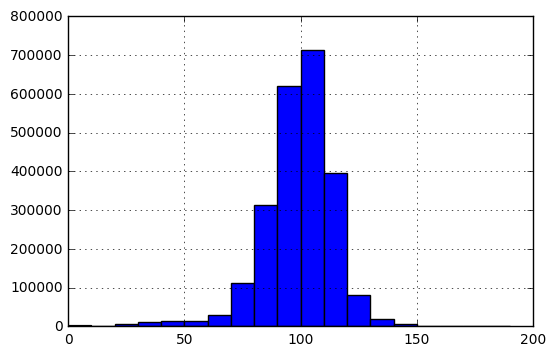

In [27]:
valid_data.MaxSpeed.hist(bins=np.arange(0,200,10));

In [28]:
valid_data.sort_values("MaxSpeed", ascending=False)

,VehicleType,Trip,Speed,MaxSpeed
515,31,"[(2016-12-18 02:29:08, 01F1774N), (2016-12-18 ...","[70.2788844622, 91.1203319502, 254.634146341]",254.634146
1920,31,"[(2016-12-18 05:25:34, 03F0301N), (2016-12-18 ...","[162.580645161, 250.434782609, 151.73553719, 1...",250.434783
13585,31,"[(2016-12-18 00:22:21, 03F2261S), (2016-12-18 ...","[221.917808219, 211.764705882, 243.076923077, ...",249.448819
13317,31,"[(2016-12-18 02:44:05, 03F0116N), (2016-12-18 ...","[166.451612903, 180.0, 175.263157895, 172.9870...",247.868852
38236,31,"[(2016-12-18 00:19:33, 03F2152S), (2016-12-18 ...","[232.615384615, 238.064516129, 217.674418605, ...",247.304348
39553,31,"[(2016-12-18 00:23:36, 03F2306S), (2016-12-18 ...","[234.97005988, 244.06779661, 210.909090909, 17...",244.067797
6333,31,"[(2016-12-18 01:54:23, 03F3588S), (2016-12-18 ...","[236.16, 243.333333333, 199.384615385, 225.0]",243.333333
7859,31,"[(2016-12-18 02:58:16, 01F3640N), (2016-12-18 ...","[219.512195122, 232.5, 172.394366197, 195.0, 1...",232.500000
25188,31,"[(2016-12-18 00:19:31, 03F2152S), (2016-12-18 ...","[229.846153846, 222.857142857, 225.0, 232.1893...",232.189349
5641,31,"[(2016-12-18 03:41:40, 03F2129S), (2016-12-18 ...",[231.683168317],231.683168


In [29]:
num_total = data.shape[0]
num_valid = valid_data.shape[0]
num_overspeed = valid_data.query("MaxSpeed > 120").shape[0]
num_total, num_valid, num_overspeed

(3350606, 2347875, 108282)

In [30]:
國道違規統計[國道違規統計["違規 項目"]=="超速"]

,違規 項目,104年,103年,102年,101年,100年,99年,98年,97年,96年,95年
1,超速,392444,415784,417088,460826,477775,493017,473948,565548,695921,609328
